In [97]:
suppressPackageStartupMessages({
    library(data.table)
    library(dplyr)
    library(glue)
    library(ggplot2)
    library(sf)
    library(patchwork)
    library(ggthemes)
    library(purrr)
    library(Matrix)
    library(tidyr)
    library(Seurat)
    library(uwot)
    library(igraph)
    library(future)
    library(scran)
    library(DESeq2)
    library(pheatmap)
    library(furrr)
    library(spatula)
    library(deldir)
    library(tidyverse)
    library(purrr)
    library(tictoc)

})
fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}


In [187]:
dmt1 <- readRDS('../data/dmt1.rds')
aggs1 <- readRDS('../data/aggs1.rds')
gene_ls = read.table('../data/VizgenLungHacohen/cells/genes.txt', header=FALSE)$V1


In [3]:
programs = read.csv('../data/NMF41.csv', header=1)
# Don't include MP24.Cilia and MP11.Translation.initiation due to non-overlapping genes
lung_programs = c('MP1..Cell.Cycle...G2.M','MP5.Stress','MP6.Hypoxia','MP2..Cell.Cycle...G1.S','MP12.EMT.I','MP18.Interferon.MHC.II..II.','MP13.EMT.II','MP14.EMT.III',
                 'MP10.Protein.maturation','MP8.Proteasomal.degradation','MP19.Epithelial.Senescence','MP3..Cell.Cylce.HMG.rich','MP23.Secreted.II','MP30.PDAC.classical')
lung_programs = programs[lung_programs]
# Get just the epithelial cells
epi_idx = which(dmt1$pts$type_lvl1=='Epithelial')
intersected_genes = sapply(lung_programs, intersect, gene_ls)

In [4]:
epi_seurat = readRDS('../data/epi_seurat.RDS')
program_score = epi_seurat@meta.data[,14:28]
weighted_adjmtx = uwot::umap(program_score, min_dist=0.3, spread=1, ret_extra='fgraph', fast_sgd=TRUE)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



In [ ]:
source('../src/cluster_utils.R')
leiden_clusters = do_leiden_one(weighted_adjmtx$fgraph, resolution=0.4, n_starts=1)

In [ ]:
# Merge new epi subtypes with the original data
epi_idx = which(dmt1$pts$type_lvl1=='Epithelial')
epi_counts = dmt1$counts[,epi_idx]
epi_meta = dmt1$pts[epi_idx,]
epi_meta$type_lvl2 <- paste('Epi', leiden_clusters, sep='')
epi_subtypes = epi_meta[,c('ORIG_ID', 'type_lvl2')]
merge_df = merge(dmt1$pts, epi_subtypes, by='ORIG_ID', all=TRUE)
# Replace column type_lvl2 where available
merge_df$type_lvl2.x = ifelse(!is.na(merge_df$type_lvl2.y), merge_df$type_lvl2.y, merge_df$type_lvl2.x)
merge_df = select(merge_df, -type_lvl2.y)
colnames(merge_df) <- c('ORIG_ID','X','Y','type_lvl1','type_lvl2','hubID','f','agg_id','spatial_cluster')
head(merge_df)


In [16]:
#write.csv(merge_df, '../data/merge_subtype_epi.csv')

In [121]:
merge_df = read.csv('../data/merge_subtype_epi.csv', row.names=1)
p1_merge_metadata = read.csv('../data/p1_merge_metadata.csv', row.names=1)
head(p1_merge_metadata)
hubtype = p1_merge_metadata[,c('ORIG_ID','hubType')]
merge_df = merge_df %>% left_join(hubtype, by='ORIG_ID')
merge_df = merge_df %>% dplyr::filter(type_lvl1 != '') # Remove cells without types
head(merge_df)

,ORIG_ID,X,Y,type_lvl1,type_lvl2,f,agg_id,spatial_cluster,hubID,hubType
,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>
1,1,7086.414,79.414864,Epithelial,Epithelial,1.189615,2,0,H260,tumor
2,3,7087.515,-21.805606,Epithelial,Epithelial,1.074691,1,13,H260,tumor
3,4,7099.331,-17.703966,Epithelial,Epithelial,2.322399,1,13,H260,tumor
4,5,7100.477,-9.060024,Epithelial,Epithelial,1.236350,1,13,H260,tumor
5,6,7093.215,-5.783358,Epithelial,Epithelial,1.425693,1,13,H260,tumor
6,7,7086.925,-4.925823,Epithelial,Epithelial,1.420925,3832,1,H260,tumor


,ORIG_ID,X,Y,type_lvl1,type_lvl2,hubID,f,agg_id,spatial_cluster,hubType
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>
1,1,7086.414,79.414864,Epithelial,Epi1,H260,1.189615,2,0,tumor
2,3,7087.515,-21.805606,Epithelial,Epi2,H260,1.074691,1,13,tumor
3,4,7099.331,-17.703966,Epithelial,Epi3,H260,2.322399,1,13,tumor
4,5,7100.477,-9.060024,Epithelial,Epi4,H260,1.236350,1,13,tumor
5,6,7093.215,-5.783358,Epithelial,Epi2,H260,1.425693,1,13,tumor
6,7,7086.925,-4.925823,Epithelial,Epi3,H260,1.420925,3832,1,tumor


In [158]:
tumor = subset(merge_df, hubType=='tumor')
# Keep only hubID with SPP1+ mac
num_spp1 = tumor %>% filter(type_lvl2=='SPP1+ Macrophage') %>%
        group_by(type_lvl2, hubID) %>% summarize(Count = n()) %>% 
        arrange(desc(Count))
enriched_hubs = subset(num_spp1, Count>1)$hubID
enriched_hubs = as.vector(enriched_hubs)
enriched_hubs

`summarise()` has grouped output by 'type_lvl2'. You can override using the
`.groups` argument.


[1] "H260" "H286" "H284" "H304" "H275" "H266" "H305" "H322" "H318" "H307"
[11] "H298" "H311" "H265" "H300" "H270" "H310" "H287" "H312" "H302" "H315"

In [147]:
# Colocalization code
coloc_one_type = function(index_type, adj, y, nperm = 100, max_dist=30, compartments=NULL, verbose=TRUE) {
    if (verbose) message(index_type)
    types = unique(y)
    i_index = which(y == index_type)
    i_shuffle = setdiff(seq_len(length(y)), i_index)

    X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+y) %>% as.matrix()
    colnames(X) = gsub('^y', '', colnames(X))
    freq = (colSums(X) / nrow(X))[types]

    freq_perm = map(seq_len(nperm), function(i) {
        set.seed(i)
        yperm = y
        if (is.null(compartments)) {
            yperm[i_shuffle] = sample(y[i_shuffle])
        } else {
            ## shuffle inside compartments, to preserve total composition within compartment
            .x = split(i_shuffle, compartments[i_shuffle]) %>%
                map(function(.i) {
                    ## CAUTION: if .i is a single number, sample will interpret it as 1:.i
                    if (length(.i) == 1) {
                        res = .i
                    } else {
                        res = sample(.i) ## shuffle non-index cells inside hub            
                    }
                   
                    names(res) = .i
                    return(res)
                }) %>%
                purrr::reduce(c)
            yperm[as.integer(names(.x))] <- y[.x]
        }

        X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+yperm) %>% as.matrix() #%>% prop.table(1)
        colnames(X) = gsub('^yperm', '', colnames(X))
        (colSums(X) / nrow(X))[types]    
    }) %>%
        purrr::reduce(rbind2)
    
    
    # Return all 0 here
    #print(apply(freq_perm, 2, sd))

    
    stats = tibble(
        type = types,
        freq,
        zscore = (freq - apply(freq_perm, 2, mean)) / apply(freq_perm, 2, sd),
        pval = exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed
        fdr = p.adjust(pval)
    ) %>%
        cbind(dplyr::rename(data.frame(t(apply(freq_perm, 2, quantile, c(.025, .975)))), q025 = `X2.5.`, q975 = `X97.5.`)) %>% ## 95% CI

    
        subset(type != index_type) %>%
        dplyr::mutate(index_type = index_type) %>%
        dplyr::select(index_type, type, everything()) %>%
        arrange(fdr)

    return(stats)    
}


coloc_all_types = function(index_types, coords, y, nperm = 100, nsteps=1, max_dist=30, compartments=NULL, parallel=TRUE, verbose=TRUE) {
    if (parallel & length(index_types) > 1) {
        plan(multicore)
    } else {
        plan(sequential)
    }

    ## Define neighbors
    ## NOTE: max_dist only refers to directly adjacent neighbors
    adj = spatula::getSpatialNeighbors(coords, return_weights = TRUE)
    adj@x[adj@x > max_dist] = 0
    adj = Matrix::drop0(adj)
    adj@x = rep(1, length(adj@x))
   
    ## If nsteps>1, consider not only your adjacent neighbors
    ##   but also your neighbor's neighbors etc.
    if (nsteps > 1) {
        adj = adj + Matrix::Diagonal(n = nrow(adj)) ## add self
        for (iter in seq_len(nsteps - 1)) {
            adj = adj %*% adj
        }
        ## Ignore weights. Only care if cell is a neighbor or not
        adj@x = rep(1, length(adj@x))
       
        ## Remove self as neighbor
        adj = adj - Matrix::Diagonal(n = nrow(adj))
        adj = Matrix::drop0(adj)
    }
       
    all_stats = index_types %>%
        future_map(coloc_one_type, adj, y, nperm, max_dist, compartments, verbose, .options = furrr::furrr_options(seed = 1)) %>%
        rbindlist()  

    # return(all_stats)
    
}



In [148]:
plan(multicore, workers = parallel::detectCores() - 1)


In [165]:
unique(test$hubID)

[1] "H260" "H265" "H287" "H286" "H318" "H322" "H275" "H266" "H304" "H298"
[11] "H300" "H305" "H307" "H312" "H310" "H284" "H302" "H311" "H315" "H270"

In [ ]:
tic()
# Just test colocalization on specifically enriched hubs
test = merge_df %>% filter(hubID %in% enriched_hubs)
nrow(test)
coloc_res = coloc_all_types(
    index_type = c('SPP1+ Macrophage'),
    coords = as.matrix(test[, c('X', 'Y')]),
    y = test$type_lvl2,
    compartments = test$agg_id,
    max_dist = 40
) 
toc()

[1] 336664

In [177]:
coloc_res = coloc_res %>% arrange(desc(zscore))
coloc_res
#write.csv(coloc_res, '../outputs/coloc_spp1_tumor_aggid.csv')

index_type,type,freq,zscore,pval,fdr,q025,q975
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SPP1+ Macrophage,MARCO+ Macrophage,0.5454009820,8.55726728,5.778719e-18,1.791403e-16,4.970671e-01,0.514700491
SPP1+ Macrophage,MMP1+SOX4+ Myeloid,0.0888379705,5.42786895,2.851544e-08,8.554633e-07,7.547954e-02,0.082541735
SPP1+ Macrophage,MERTK+ Macrophage,0.2398690671,3.47560130,2.548547e-04,7.390787e-03,2.231686e-01,0.234407529
SPP1+ Macrophage,NCAM1+ S100B+ SEPP1+ Myeloid,0.0743044190,3.06592871,1.084975e-03,3.037931e-02,6.618658e-02,0.072805237
SPP1+ Macrophage,CXCL10+ Macrophage,0.0550572831,2.80755117,2.495987e-03,6.739166e-02,4.605074e-02,0.053031097
SPP1+ Macrophage,CD8 T,0.0693944354,2.14869036,1.582948e-02,4.115664e-01,6.251718e-02,0.069301146
SPP1+ Macrophage,Treg,0.0630441899,1.93567556,2.645372e-02,6.613431e-01,5.658429e-02,0.062461538
SPP1+ Macrophage,FCN1+LYZ+ Macrophage,0.0782978723,1.64608479,4.987315e-02,1.000000e+00,7.143208e-02,0.078463175
SPP1+ Macrophage,LAMP3+CD1C+ DC,0.0278232406,1.48586660,6.865720e-02,1.000000e+00,2.382979e-02,0.028188216


## What if we do colocalization test on tiles instead of hubs?

In [182]:
# Keep only agg_id with SPP1+ mac
num_spp1 = tumor %>% filter(type_lvl2=='SPP1+ Macrophage') %>%
        group_by(type_lvl2, agg_id) %>% summarize(Count = n()) %>% 
        arrange(desc(Count))
num_spp1 = num_spp1 %>% filter(Count > 1)
head(num_spp1)
enriched_tiles = num_spp1$agg_id
length(enriched_tiles)

`summarise()` has grouped output by 'type_lvl2'. You can override using the
`.groups` argument.


type_lvl2,agg_id,Count
<chr>,<int>,<int>
SPP1+ Macrophage,6469,33
SPP1+ Macrophage,4230,32
SPP1+ Macrophage,7511,30
SPP1+ Macrophage,19927,30
SPP1+ Macrophage,6477,29
SPP1+ Macrophage,7421,29


[1] 2473

In [184]:
tic()
# Just test colocalization on specifically enriched hubs
test = merge_df %>% filter(agg_id %in% enriched_tiles)
nrow(test)
coloc_res = coloc_all_types(
    index_type = c('SPP1+ Macrophage'),
    coords = as.matrix(test[, c('X', 'Y')]),
    y = test$type_lvl2,
    compartments = test$agg_id,
    max_dist = 40
) 
toc()

[1] 82636

SPP1+ Macrophage



256.635 sec elapsed


In [185]:
coloc_res = coloc_res %>% arrange(desc(zscore))
coloc_res
#write.csv(coloc_res, '../outputs/coloc_spp1_tumor_aggid.csv')

index_type,type,freq,zscore,pval,fdr,q025,q975
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SPP1+ Macrophage,MARCO+ Macrophage,0.5861491629,7.488141703,3.492779e-14,1.082762e-12,0.5438508371,0.560761035
SPP1+ Macrophage,MMP1+SOX4+ Myeloid,0.0951293760,4.404178038,5.309286e-06,1.592786e-04,0.0813146880,0.089726027
SPP1+ Macrophage,NCAM1+ S100B+ SEPP1+ Myeloid,0.0821156773,2.732618433,3.141654e-03,9.110796e-02,0.0733999239,0.081641933
SPP1+ Macrophage,CXCL10+ Macrophage,0.0566210046,2.309786621,1.044999e-02,2.925996e-01,0.0487385845,0.055936073
SPP1+ Macrophage,MERTK+ Macrophage,0.2507610350,2.166999980,1.511743e-02,4.081706e-01,0.2353843227,0.248881279
SPP1+ Macrophage,FCN1+LYZ+ Macrophage,0.0834094368,1.473348699,7.032852e-02,1.000000e+00,0.0770852359,0.084863014
SPP1+ Macrophage,LAMP3+CCL19+ mreg DC,0.0051750381,1.356940589,8.740004e-02,1.000000e+00,0.0034969559,0.005483257
SPP1+ Macrophage,LAMP3+CD1C+ DC,0.0296042618,1.319440819,9.351089e-02,1.000000e+00,0.0258713851,0.030753425
SPP1+ Macrophage,FLT3+ DC,0.0165144597,1.317973070,9.375633e-02,1.000000e+00,0.0137747336,0.016971081


## Where are these macrophages in the sample? Where are the epithelials in the sample?

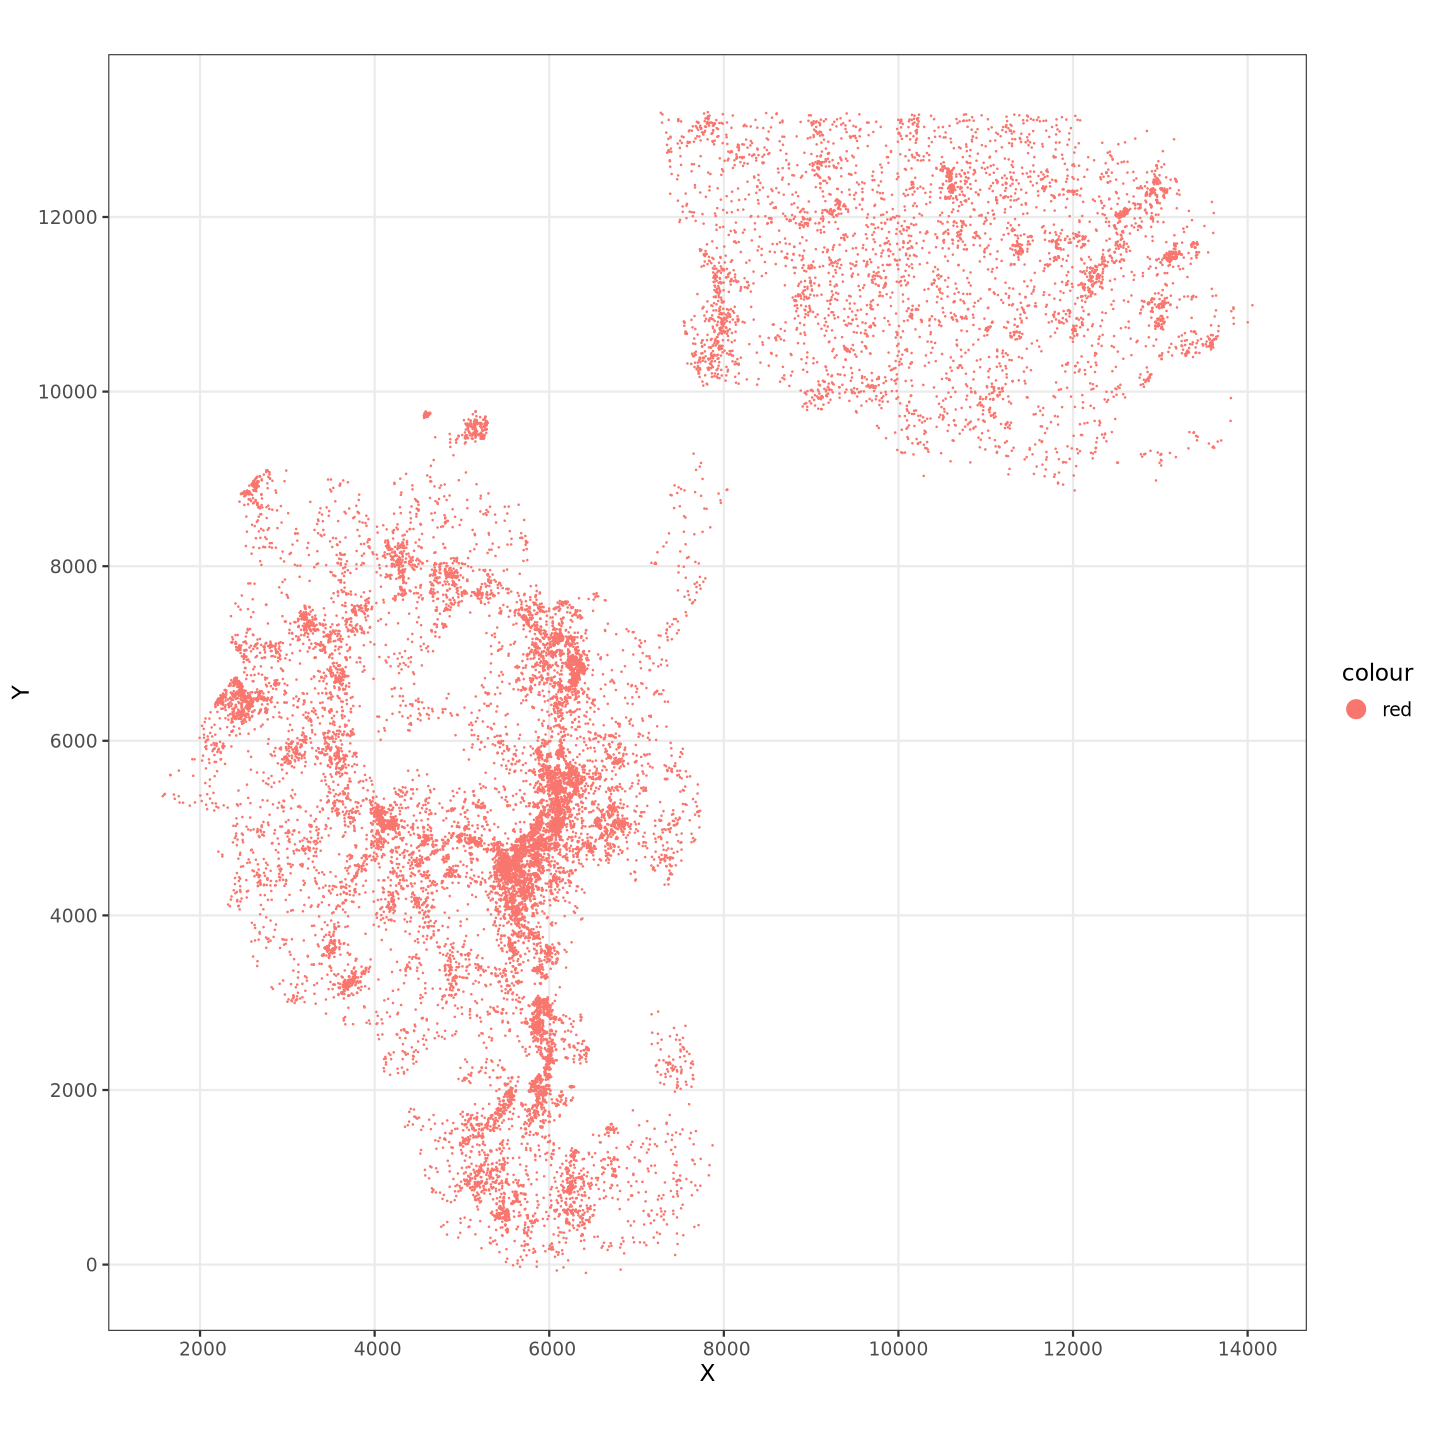

In [192]:

spp1_mac = dmt1$pts %>% filter(type_lvl2=='SPP1+ Macrophage')
fig.size(12,12)

ggplot() +
    geom_point(data=spp1_mac, aes(X, Y, color='red'),  size=0.1) +
    theme_bw(base_size=14) +
    coord_sf() +
    guides(color=guide_legend(override.aes=list(size=5))) + # Increase marker size
    NULL

